# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm
import os

/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1rPupavaoY_D5F-DDZLHatHqH8MCal0yo' # The shareable link # The shareable link

In [4]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1rPupavaoY_D5F-DDZLHatHqH8MCal0yo


In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('mydata.csv')  
df3 = pd.read_csv('mydata.csv')

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

In [0]:
display['COUNT(*)'].sum()

393063

In [0]:
filtered_data=df3

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 11)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 11)


5    59521
4    14071
1     8886
2     5295
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:53<00:00, 1625.75it/s]


In [24]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
def func(x):
  if x>3:
    return 1
  
  else:
    return 0

In [0]:
x=preprocessed_reviews
y=final['Score'].apply(func)

In [0]:
from sklearn.model_selection import train_test_split
x1,xtest,y1,ytest=train_test_split(x,y,test_size=0.3,random_state=1)

In [0]:
xtrain,xcv,ytrain,ycv=train_test_split(x1,y1,test_size=0.2,random_state=1)

In [29]:

print(len(xtrain))
print(ytrain.shape)
print(len(xtest))
print(ytest.shape)
print(len(xcv))
print(ycv.shape)

49152
(49152,)
26332
(26332,)
12289
(12289,)


In [0]:
wordslengthtrain=[len(mike.split()) for mike in xtrain]
wordslengthtest=[len(mike.split()) for mike in xtest]
wordlenghtcv=[len(mike.split()) for mike in xcv]

In [33]:
print(wordslengthtrain)
wordy=pd.DataFrame(wordslengthtrain)
wordy1=pd.DataFrame(wordslengthtest)
wordy2=pd.DataFrame(wordlenghtcv)

[12, 15, 50, 31, 12, 19, 131, 152, 14, 26, 12, 18, 21, 20, 58, 20, 16, 282, 67, 38, 33, 44, 13, 28, 10, 77, 14, 56, 10, 32, 12, 16, 16, 58, 32, 21, 28, 32, 58, 33, 45, 21, 18, 109, 27, 10, 33, 31, 35, 26, 30, 110, 82, 10, 117, 10, 25, 59, 13, 39, 30, 37, 47, 30, 32, 11, 39, 126, 18, 40, 44, 113, 59, 17, 36, 26, 78, 20, 34, 12, 16, 34, 16, 11, 17, 31, 21, 24, 43, 54, 37, 90, 0, 20, 27, 18, 53, 118, 13, 15, 29, 12, 11, 17, 17, 17, 95, 36, 61, 8, 103, 81, 40, 80, 45, 101, 53, 48, 14, 27, 17, 13, 10, 64, 41, 45, 54, 11, 55, 69, 9, 26, 38, 16, 35, 29, 41, 24, 13, 26, 17, 12, 26, 13, 66, 30, 15, 41, 36, 41, 135, 12, 19, 188, 73, 28, 27, 50, 35, 14, 12, 27, 87, 10, 19, 77, 42, 98, 102, 23, 19, 28, 76, 45, 29, 55, 38, 11, 17, 25, 28, 110, 13, 28, 29, 22, 48, 26, 28, 42, 12, 18, 23, 10, 59, 35, 54, 25, 32, 36, 34, 17, 90, 131, 53, 14, 25, 23, 29, 25, 96, 28, 86, 54, 13, 14, 24, 19, 78, 17, 15, 28, 19, 25, 8, 21, 17, 14, 33, 35, 80, 17, 52, 22, 59, 52, 13, 125, 131, 18, 126, 170, 41, 26, 22, 29,

# [4] Featurization

## [4.1] BAG OF WORDS

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer(min_df=2)
xtrainonehotencoding=count_vect.fit_transform(xtrain)
xtestonehotencoding=count_vect.transform(xtest)
xcvonehotencoding=count_vect.transform(xcv)
print(xtrainonehotencoding.shape)
print(xtestonehotencoding.shape)
print(xcvonehotencoding.shape)

(49152, 21732)
(26332, 21732)
(12289, 21732)


In [0]:
from scipy.sparse import hstack
xtrainonehotencoding1=hstack((xtrainonehotencoding,wordy))
xtestonehotencoding1=hstack((xtestonehotencoding,wordy1))
xcvonehotencoding1=hstack((xcvonehotencoding,wordy2))

In [35]:
print(xtrainonehotencoding1.shape)
print(xtestonehotencoding1.shape)
print(xcvonehotencoding1.shape)

(49152, 41231)
(26332, 41231)
(12289, 41231)


## [4.2] Bi-Grams and n-Grams.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer(ngram_range=(1,2))
xtrainonehotencoding2=count_vect.fit_transform(xtrain)
xtestonehotencoding2=count_vect.transform(xtest)
xcvonehotencoding2=count_vect.transform(xcv)
print(xtrainonehotencoding2.shape)
print(xtestonehotencoding2.shape)
print(xcvonehotencoding2.shape)

(49152, 909237)
(26332, 909237)
(12289, 909237)


## [4.3] TF-IDF

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf= TfidfVectorizer(min_df=2)
xtraintfidfencoding=tfidf.fit_transform(xtrain)
xtesttfidfencoding=tfidf.transform(xtest)
xcvtfidfencoding=tfidf.transform(xcv)
print(xtraintfidfencoding.shape)
print(xtesttfidfencoding.shape)
print(xcvtfidfencoding.shape)

(49152, 21732)
(26332, 21732)
(12289, 21732)


In [0]:
from scipy.sparse import hstack
xtraintfidfencoding1=hstack((xtraintfidfencoding,wordy))
xtesttfidfencoding1=hstack((xtesttfidfencoding,wordy1))
xcvtfidfencoding1=hstack((xcvtfidfencoding,wordy2))

## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in xtrain:
    list_of_sentance.append(sentance.split())

In [60]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.857511043548584), ('good', 0.8289104700088501), ('fantastic', 0.8006715178489685), ('terrific', 0.7948583960533142), ('excellent', 0.7816588282585144), ('wonderful', 0.7786215543746948), ('perfect', 0.7518824934959412), ('amazing', 0.744175136089325), ('incredible', 0.7056276798248291), ('fabulous', 0.6925656199455261)]
[('greatest', 0.7315977215766907), ('best', 0.7184104919433594), ('tastiest', 0.6797229051589966), ('experienced', 0.6301275491714478), ('horrible', 0.6258659958839417), ('nastiest', 0.6062277555465698), ('hardly', 0.6023961305618286), ('hottest', 0.5979480147361755), ('nicest', 0.5887228846549988), ('superior', 0.5862823128700256)]


In [61]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13250
sample words  ['baby', 'food', 'convenient', 'healthy', 'great', 'not', 'worry', 'son', 'eating', 'able', 'grab', 'pinch', 'hot', 'chocolate', 'better', 'green', 'one', 'kids', 'enjoy', 'ease', 'making', 'best', 'buy', 'ordered', 'whim', 'reading', 'reviews', 'disappointed', 'sugar', 'flavorful', 'want', 'go', 'back', 'using', 'regular', 'brown', 'problem', 'trying', 'eat', 'sometimes', 'find', 'sneaking', 'teaspoons', 'bag', 'p', 'use', 'regularly', 'coffee', 'oatmeal', 'etc']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [62]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(xtrain): # for each review/sentence
   
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
      
      if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 49152/49152 [01:27<00:00, 562.20it/s]

49152
50


In [63]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectorstest = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(xtest): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectorstest.append(sent_vec)
print(len(sent_vectorstest))
print(len(sent_vectorstest))

100%|██████████| 26332/26332 [00:48<00:00, 539.10it/s]

26332
26332


In [64]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectorscv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(xcv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectorscv.append(sent_vec)
print(len(sent_vectorscv))
print(len(sent_vectorscv))

100%|██████████| 12289/12289 [00:25<00:00, 491.42it/s]

12289
12289


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
model = TfidfVectorizer()
xtraintfidfw2v = model.fit_transform(xtrain)

tfidf_feat = model.get_feature_names()
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [66]:
xcvtfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(xcv): # for each review/sentence 
    sent_vec = np.zeros(50)
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    xcvtfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 12289/12289 [06:20<00:00, 34.32it/s]


In [67]:
xtraintfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(xtrain): # for each review/sentence 
    sent_vec = np.zeros(50)
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    xtraintfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 49152/49152 [19:52<00:00, 41.22it/s]


In [68]:
xtesttfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(xtest): # for each review/sentence 
    sent_vec = np.zeros(50)
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    xtesttfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [10:52<00:00, 40.37it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [37]:
#with hyper parameter tuning
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
cvscores=[]
cvscores1=[]
min_samples_split=[i for i in [5,10,100,200,300,400,500]]
depth=[i for i in [1,5,10,50,100,500,1000]]
for i in min_samples_split:
  for j in depth:
    knnx=DecisionTreeClassifier(min_samples_split=i,max_depth=j)
    knnx.fit(xtrainonehotencoding,ytrain)
    predict1=knnx.predict_proba(xtrainonehotencoding)[:,1]
    predix=knnx.predict(xtrainonehotencoding)
    cvscores.append(roc_auc_score(ytrain,predict1))
    predict2=knnx.predict_proba(xcvonehotencoding)[:,1]
    cvscores1.append(roc_auc_score(ycv,predict2))
optimal_k=np.argmax(cvscores1)
print(cvscores)
print(cvscores1)

[0.6066502171091797, 0.710468830759999, 0.7882162774413658, 0.9682332706353953, 0.9910039476286333, 0.9995591715333053, 0.9995723302035581, 0.6066502171091797, 0.7104218116697372, 0.7870378147971496, 0.9659002636605591, 0.9889239897672423, 0.9980093649375882, 0.9980886200907754, 0.6066502171091797, 0.7101854837891596, 0.7811099647460623, 0.9398562468782222, 0.9670200335832535, 0.9813982484764243, 0.9818159532019326, 0.6066502171091797, 0.709726577651919, 0.778727735617963, 0.9241799609322066, 0.9521833580645398, 0.9685356934679391, 0.969396475652184, 0.6066502171091797, 0.709726577651919, 0.7785308837481438, 0.9128220459004976, 0.9416345489220544, 0.9591876991029669, 0.9595473510515917, 0.6066502171091797, 0.7095603390189087, 0.7773727232710274, 0.9005692387167449, 0.9310354275770657, 0.9502436246273246, 0.9513140713528657, 0.6066502171091797, 0.7095603390189087, 0.7772671415915267, 0.8976546032070578, 0.9255150262966265, 0.9463199081838052, 0.9460403534207862]
[0.6027715309133982, 0.7

In [0]:
depthsy=depth*7
estimators2=[[i]*7 for i in min_samples_split]
estimatorsy=np.array(estimators2).flatten()


for training data


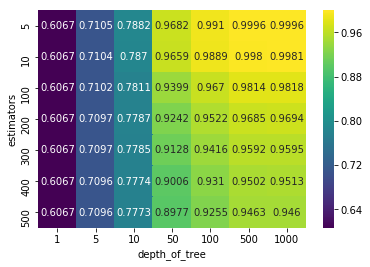

In [39]:
print('for training data')
dat=pd.DataFrame(np.round(cvscores,4),columns=['a'])
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

for cv data


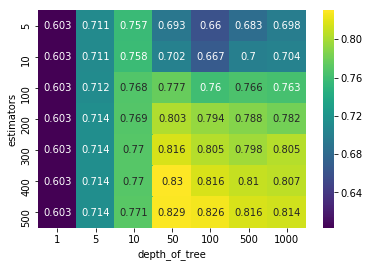

In [40]:
print('for cv data')
dat['a']=pd.DataFrame(np.round(cvscores1,3))
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

0.8214617086070819


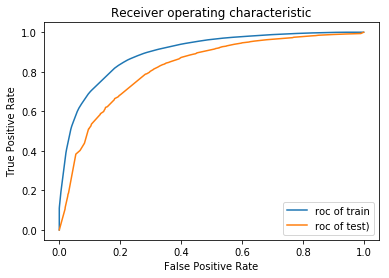

In [134]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
knne=DecisionTreeClassifier(min_samples_split=500,max_depth=50)
knne.fit(xtrainonehotencoding,ytrain)
predictrain=knne.predict_proba(xtrainonehotencoding)[:,1]
predictra=knne.predict(xtrainonehotencoding)
fpr, tpr, thresh = metrics.roc_curve(ytrain, predictrain)
auc = metrics.roc_auc_score(ytrain, predictrain)
plt.plot(fpr,tpr,label="roc of train")
plt.legend()
predic=knne.predict_proba(xtestonehotencoding)[:,1]
predictra1=knne.predict(xtestonehotencoding)
fpr, tpr, thresh = metrics.roc_curve(ytest, predic)
auc = metrics.roc_auc_score(ytest, predic)
plt.plot(fpr,tpr,label="roc of test)")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
print(roc_auc_score(ytest, predic))

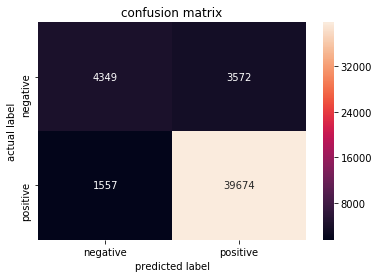

In [48]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest1=confusion_matrix(ytrain,predictra)
import seaborn as sns
classlabel=['negative','positive']

frame1=pd.DataFrame(rest1,index=classlabel,columns=classlabel)
sns.heatmap(frame1,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()

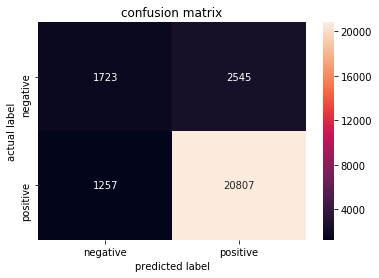

In [47]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest=confusion_matrix(ytest,predictra1)
rest1=confusion_matrix(ytrain,predix)
import seaborn as sns

classlabel=['negative','positive']

frame=pd.DataFrame(rest,index=classlabel,columns=classlabel)
sns.heatmap(frame,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()


### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [51]:

knne=DecisionTreeClassifier(min_samples_split=300,max_depth=50)
knne.fit(xtrainonehotencoding,ytrain)
print(knne.feature_importances_)
c=np.argsort(knne.feature_importances_)
c=c[::-1]
p=c[::-1]

[0. 0. 0. ... 0. 0. 0.]


In [52]:
d=count_vect.get_feature_names()
print(d)

['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaaand', 'aaah', 'aaahs', 'aachen', 'aaf', 'aafco', 'aahhhs', 'aahing', 'aahs', 'aamazon', 'aarti', 'aasanfood', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abb', 'abbaye', 'abbott', 'abbreviated', 'abby', 'abc', 'abcessed', 'abd', 'abdomen', 'abdominal', 'abe', 'abetter', 'abid', 'abide', 'abiding', 'abilities', 'ability', 'abit', 'abita', 'ablaze', 'able', 'ablution', 'abnormal', 'abnormalities', 'abnormally', 'abnoxious', 'abode', 'abolitionists', 'abolutely', 'abolutley', 'abomination', 'aboout', 'aborio', 'aboslutely', 'abosolutly', 'abosoutely', 'abosutely', 'abot', 'abottle', 'abou', 'aboulutely', 'abound', 'abounds', 'abour', 'aboutthe', 'aboveour', 'abovethirst', 'abowl', 'abrasions', 'abrasive', 'abroad', 'abrubt', 'abrupt', 'abruptly', 'abruptness', 'abruzzo', 'abs', 'absalutely', 'abscess', 'absconded', 'absconding', 'absence', 'absensce', 'absent', 'absoloutely', 'absolustely', 'absolut', 'absolu

In [0]:
out1=[d[i] for i in c[:10]]
print(out1)
out2=[d[i] for i in p[:10]]
print(out2)

['not', 'great', 'disappointed', 'worst', 'horrible', 'money', 'best', 'return', 'delicious', 'good']
['aa', 'politicians', 'politics', 'pollack', 'pollard', 'polled', 'pollen', 'pollenalso', 'pollens', 'pollinators']


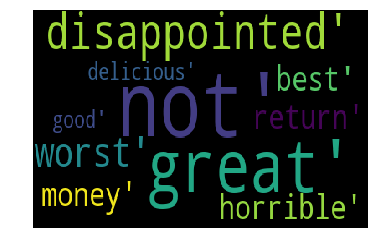

In [0]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt1
word_cloud = WordCloud(relative_scaling = 1.0).generate(str(out1))
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()


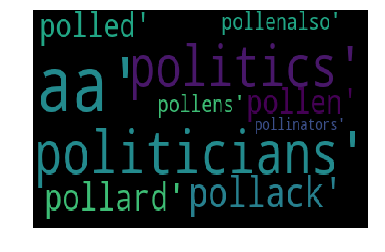

In [0]:
word_cloud = WordCloud(relative_scaling = 1.0).generate(str(out2))
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [54]:
from sklearn import tree
knne=DecisionTreeClassifier(min_samples_split=100,max_depth=3)
knne.fit(xtrainonehotencoding,ytrain)
 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

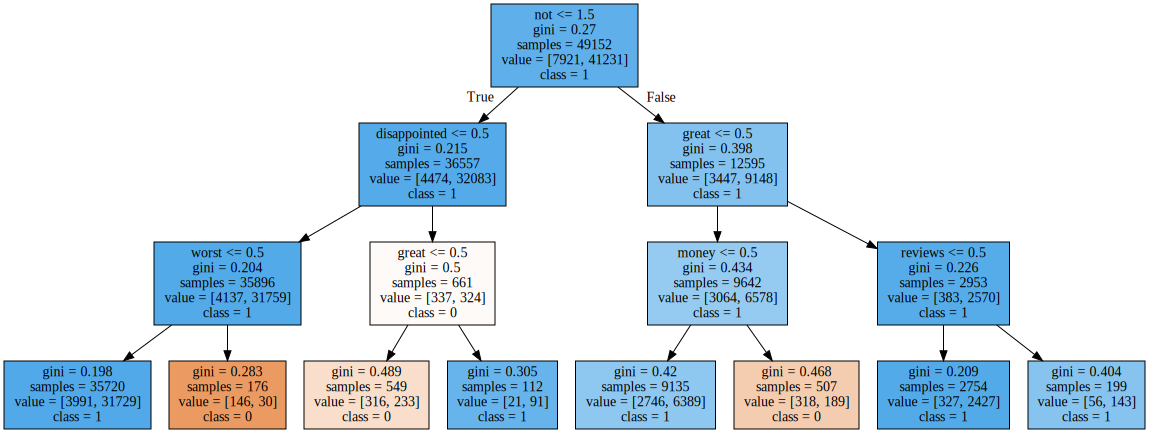

In [55]:

from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(tree.export_graphviz(knne, out_file=None
   , feature_names=d, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [76]:
#with hyper parameter tuning
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
cvscores=[]
cvscores1=[]
min_samples_split=[i for i in [5,10,100,500]]
depth=[i for i in [1,5,10,50,100,500,1000]]
for i in min_samples_split:
  for j in depth:
    knnx=DecisionTreeClassifier(min_samples_split=i,max_depth=j)
    knnx.fit(xtraintfidfencoding,ytrain)
    predict1=knnx.predict_proba(xtraintfidfencoding)[:,1]
    predix=knnx.predict(xtraintfidfencoding)
    cvscores.append(roc_auc_score(ytrain,predict1))
    predict2=knnx.predict_proba(xcvtfidfencoding)[:,1]
    cvscores1.append(roc_auc_score(ycv,predict2))
optimal_k=np.argmax(cvscores1)
print(cvscores)
print(cvscores1)

[0.6230272898940731, 0.7033912864850236, 0.7679462147413967, 0.965060293455769, 0.987999983196095, 0.999721391375226, 0.9996872798764592, 0.6230272898940731, 0.7033912864850236, 0.766830705502741, 0.96053486370776, 0.9851392775663754, 0.9985996495657037, 0.9986915107096832, 0.6230272898940731, 0.7028730737080794, 0.7622288865737047, 0.9384655721619013, 0.9664133216681327, 0.985271369488354, 0.9858634484110054, 0.6230272898940731, 0.702505932263832, 0.7592208911023327, 0.8982678875679488, 0.9306830324169222, 0.9604330589263993, 0.959961050764723]
[0.6306255906407021, 0.7042043087373288, 0.7412460368813313, 0.68112717452309, 0.6878099949570058, 0.6884908527964435, 0.6908901264960785, 0.6306255906407021, 0.7047057317353321, 0.7433912838885892, 0.6941141520534894, 0.7064340687992331, 0.7006058857163139, 0.7006443760864571, 0.6306255906407021, 0.7056940737603226, 0.7536171928658598, 0.7703990673776, 0.7698450400611867, 0.7483849645449818, 0.749966994324779, 0.6306255906407021, 0.70580079373

In [0]:
depthsy=depth*7
estimators2=[[i]*7 for i in min_samples_split]
estimatorsy=np.array(estimators2).flatten()


for training data


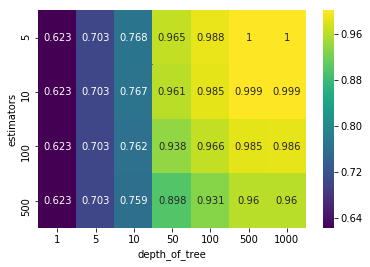

In [78]:
print('for training data')
dat=pd.DataFrame(np.round(cvscores,3),columns=['a'])
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

for cv data


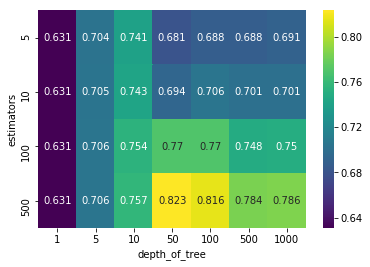

In [79]:
print('for cv data')
dat['a']=pd.DataFrame(np.round(cvscores1,3))
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

0.8192533580423449


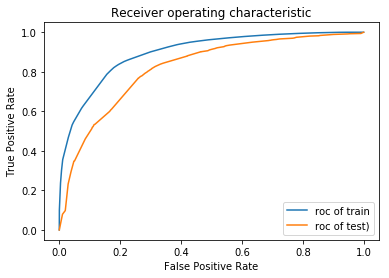

In [80]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
knne=DecisionTreeClassifier(min_samples_split=500,max_depth=50)
knne.fit(xtraintfidfencoding,ytrain)
predictrain=knne.predict_proba(xtraintfidfencoding)[:,1]
predictra=knne.predict(xtraintfidfencoding)
fpr, tpr, thresh = metrics.roc_curve(ytrain, predictrain)
auc = metrics.roc_auc_score(ytrain, predictrain)
plt.plot(fpr,tpr,label="roc of train")
plt.legend()
predic=knne.predict_proba(xtesttfidfencoding)[:,1]
predictra1=knne.predict(xtesttfidfencoding)
fpr, tpr, thresh = metrics.roc_curve(ytest, predic)
auc = metrics.roc_auc_score(ytest, predic)
plt.plot(fpr,tpr,label="roc of test)")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
print(roc_auc_score(ytest, predic))

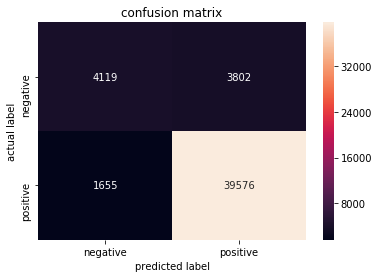

In [81]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest1=confusion_matrix(ytrain,predictra)
import seaborn as sns
classlabel=['negative','positive']

frame1=pd.DataFrame(rest1,index=classlabel,columns=classlabel)
sns.heatmap(frame1,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()

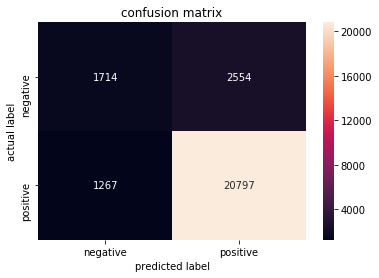

In [82]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest=confusion_matrix(ytest,predictra1)
rest1=confusion_matrix(ytrain,predix)
import seaborn as sns

classlabel=['negative','positive']

frame=pd.DataFrame(rest,index=classlabel,columns=classlabel)
sns.heatmap(frame,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()


### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [0]:

knne=DecisionTreeClassifier(min_samples_split=500,max_depth=50)
knne.fit(xtraintfidfencoding,ytrain)
print(knne.feature_importances_)
c=np.argsort(knne.feature_importances_)
p=c[::-1]

[0. 0. 0. ... 0. 0. 0.]


In [0]:
d=tfidf.get_feature_names()
print(d)

['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaaand', 'aaah', 'aaahs', 'aachen', 'aaf', 'aafco', 'aahhhs', 'aahing', 'aahs', 'aamazon', 'aarti', 'aasanfood', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abb', 'abbaye', 'abbott', 'abbreviated', 'abby', 'abc', 'abcessed', 'abd', 'abdomen', 'abdominal', 'abe', 'abetter', 'abid', 'abide', 'abiding', 'abilities', 'ability', 'abit', 'abita', 'ablaze', 'able', 'ablution', 'abnormal', 'abnormalities', 'abnormally', 'abnoxious', 'abode', 'abolitionists', 'abolutely', 'abolutley', 'abomination', 'aboout', 'aborio', 'aboslutely', 'abosolutly', 'abosoutely', 'abosutely', 'abot', 'abottle', 'abou', 'aboulutely', 'abound', 'abounds', 'abour', 'aboutthe', 'aboveour', 'abovethirst', 'abowl', 'abrasions', 'abrasive', 'abroad', 'abrubt', 'abrupt', 'abruptly', 'abruptness', 'abruzzo', 'abs', 'absalutely', 'abscess', 'absconded', 'absconding', 'absence', 'absensce', 'absent', 'absoloutely', 'absolustely', 'absolut', 'absolu

In [0]:
out1=[d[i] for i in c[:10]]
print(out1)
out2=[d[i] for i in p[:10]]
print(out2)

['aa', 'polyricinoleate', 'polysaccharides', 'polysorbate', 'polystyrene', 'polyunsat', 'polyunsaturate', 'polyunsaturated', 'polyphosphates', 'polyuria']
['not', 'great', 'disappointed', 'money', 'worst', 'horrible', 'return', 'best', 'awful', 'terrible']


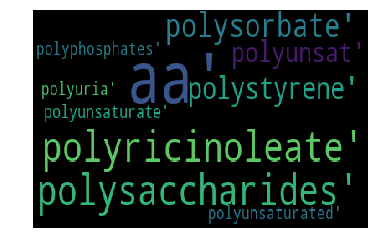

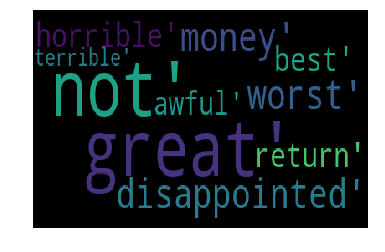

In [0]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt1
word_cloud = WordCloud(relative_scaling = 1.0).generate(str(out1))
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()
word_cloud = WordCloud(relative_scaling = 1.0).generate(str(out2))
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [0]:
from sklearn import tree
knne=DecisionTreeClassifier(min_samples_split=100,max_depth=3)
knne.fit(xtraintfidfencoding,ytrain)
 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

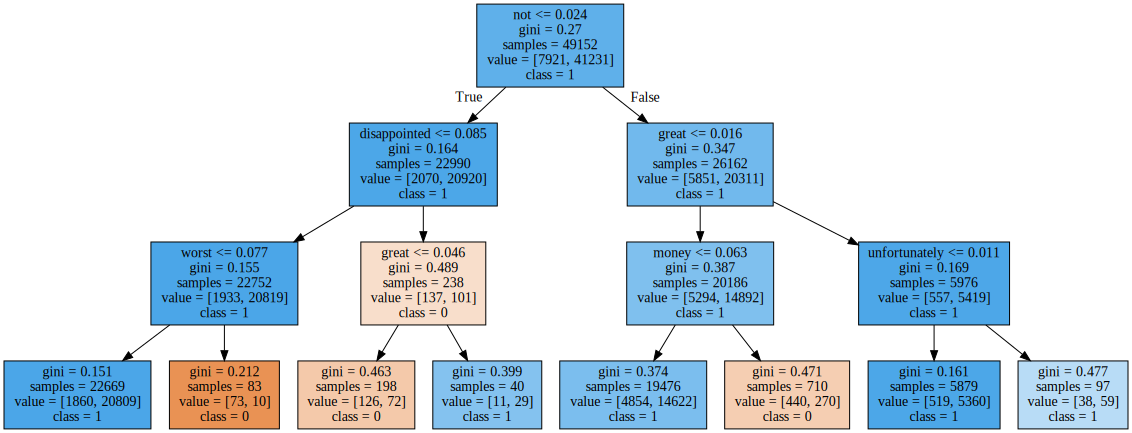

In [0]:

from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(tree.export_graphviz(knne, out_file=None
   , feature_names=d, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [83]:

#with hyper parameter tuning
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
cvscores=[]
cvscores1=[]
min_samples_split=[i for i in [40,60,80,100,120]]
depth=[i for i in [3,5,7,9,11]]
for i in min_samples_split:
  for j in depth:
    knnx=DecisionTreeClassifier(min_samples_split=i,max_depth=j)
    knnx.fit(sent_vectors,ytrain)
    predict1=knnx.predict_proba(sent_vectors)[:,1]
    cvscores.append(roc_auc_score(ytrain,predict1))
    predict2=knnx.predict_proba(sent_vectorscv)[:,1]
    cvscores1.append(roc_auc_score(ycv,predict2))
    optimal_k=np.argmax(cvscores1)
print(cvscores)
print(cvscores1)

[0.7605536293953408, 0.8140773389507286, 0.8509884561917677, 0.8849615676960797, 0.9145409463846084, 0.7605536293953408, 0.8140773389507286, 0.8508253116451544, 0.882830781695958, 0.90741535573982, 0.7605536293953408, 0.8140773389507286, 0.8506491354986352, 0.8807973928202273, 0.9024314714901402, 0.7605536293953408, 0.8140773389507286, 0.8504749465486241, 0.8790484930174891, 0.8988051409943326, 0.7605536293953408, 0.8140773389507286, 0.8504749465486241, 0.8768138277743205, 0.8946518941683073]
[0.7576872265209229, 0.8013960279303092, 0.8120229778002952, 0.8090027878826171, 0.7923146407129928, 0.7576872265209229, 0.8013960279303092, 0.8119361246091485, 0.8105141504153937, 0.8021159367975934, 0.7576872265209229, 0.8013960279303092, 0.8121026155705664, 0.812912351552466, 0.8058157657336152, 0.7576872265209229, 0.8013960279303092, 0.8117105452011015, 0.8131816378849378, 0.80798928939025, 0.7576872265209229, 0.8013960279303092, 0.8118016642660768, 0.8133739191007011, 0.8092039177395217]


In [0]:
depthsy=depth*5
estimators2=[[i]*5 for i in min_samples_split]
estimatorsy=np.array(estimators2).flatten()


for training data


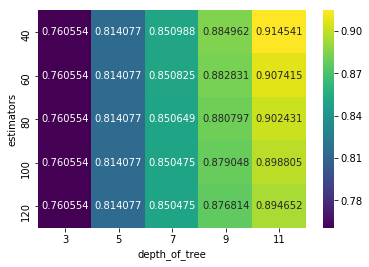

In [85]:
print('for training data')
dat=pd.DataFrame(cvscores,columns=['a'])
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

for cv data


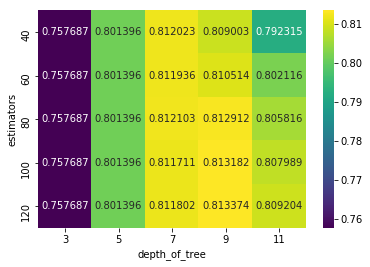

In [86]:
print('for cv data')
dat['a']=pd.DataFrame(cvscores1)
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

0.8174059802513672


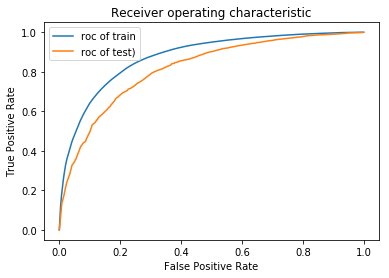

In [135]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
knne=DecisionTreeClassifier(min_samples_split=120,max_depth=9)
knne.fit(sent_vectors,ytrain)
predictrain=knne.predict_proba(sent_vectors)[:,1]
predictra=knne.predict(sent_vectors)
fpr, tpr, thresh = metrics.roc_curve(ytrain, predictrain)
auc = metrics.roc_auc_score(ytrain, predictrain)
plt.plot(fpr,tpr,label="roc of train")
plt.legend()
predic=knne.predict_proba(sent_vectorstest)[:,1]
predictra1=knne.predict(sent_vectorstest)
fpr, tpr, thresh = metrics.roc_curve(ytest, predic)
auc = metrics.roc_auc_score(ytest, predic)
plt.plot(fpr,tpr,label="roc of test)")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
print(roc_auc_score(ytest, predic))

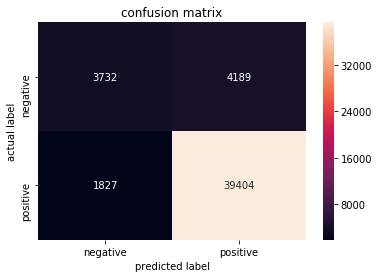

In [136]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest1=confusion_matrix(ytrain,predictra)
import seaborn as sns
classlabel=['negative','positive']

frame1=pd.DataFrame(rest1,index=classlabel,columns=classlabel)
sns.heatmap(frame1,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()

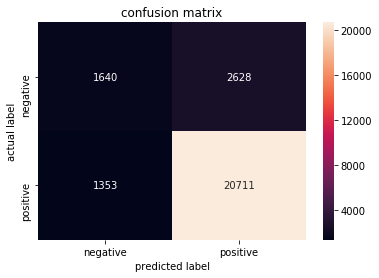

In [137]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest=confusion_matrix(ytest,predictra1)
import seaborn as sns
classlabel=['negative','positive']

frame=pd.DataFrame(rest,index=classlabel,columns=classlabel)
sns.heatmap(frame,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [90]:

#with hyper parameter tuning
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
cvscores=[]
cvscores1=[]
estimators=[i for i in [40,60,80,100,120]]
depth=[i for i in [3,5,7,9,11]]
for i in estimators:
  for j in depth:
    knnx=DecisionTreeClassifier(min_samples_split=i,max_depth=j)
    knnx.fit( xtraintfidf_sent_vectors,ytrain)
    predict1=knnx.predict_proba( xtraintfidf_sent_vectors)[:,1]
    cvscores.append(roc_auc_score(ytrain,predict1))
    predict2=knnx.predict_proba( xcvtfidf_sent_vectors)[:,1]
    cvscores1.append(roc_auc_score(ycv,predict2))
    optimal_k=np.argmax(cvscores1)
print(cvscores)
print(cvscores1)

[0.7371633987271122, 0.7826362480179361, 0.8192148099135853, 0.8571626818666398, 0.8939733415781882, 0.7371633987271122, 0.7826362480179361, 0.8192148099135853, 0.8558312877635654, 0.8882641045765561, 0.7371633987271122, 0.7826362480179361, 0.819146211828883, 0.8543082271794035, 0.8845411944932882, 0.7371633987271122, 0.7826362480179361, 0.8189642761806197, 0.8527383878669608, 0.8805525251999557, 0.7371633987271122, 0.7826362480179361, 0.8185917487908284, 0.8514045763653607, 0.8759589658434632]
[0.7270584474442394, 0.770355823605191, 0.7837160529073661, 0.7809133006728283, 0.7674532255466461, 0.7270584474442394, 0.770355823605191, 0.7836203266986563, 0.7816961738378198, 0.7745521027491533, 0.7270584474442394, 0.770355823605191, 0.7836814383883012, 0.7826468786674328, 0.7763199783693384, 0.7270584474442394, 0.770355823605191, 0.7836802439436292, 0.7830502109438043, 0.7775083776886706, 0.7270584474442394, 0.770355823605191, 0.7833824371975617, 0.7844164850135709, 0.7812961080019798]


In [0]:
depthsy=depth*5
estimators2=[[i]*5 for i in estimators]
estimatorsy=np.array(estimators2).flatten()


for training data


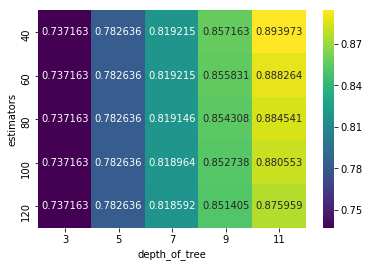

In [92]:
print('for training data')
dat=pd.DataFrame(cvscores,columns=['a'])
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

for cv data


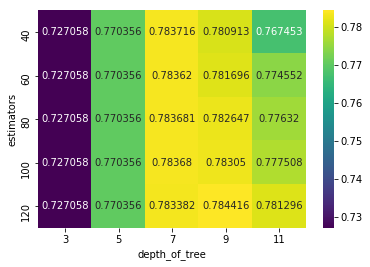

In [93]:
print('for cv data')
dat['a']=pd.DataFrame(cvscores1)
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

0.7832599681900076


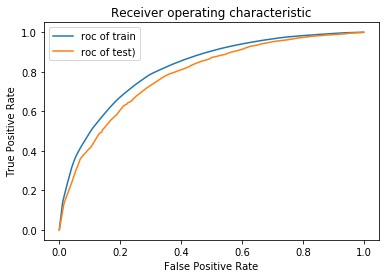

In [139]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
knne=DecisionTreeClassifier(min_samples_split=120,max_depth=7)
knne.fit( xtraintfidf_sent_vectors,ytrain)
predictrain=knne.predict_proba( xtraintfidf_sent_vectors)[:,1]
predictra=knne.predict(xtraintfidf_sent_vectors)
fpr, tpr, thresh = metrics.roc_curve(ytrain, predictrain)
auc = metrics.roc_auc_score(ytrain, predictrain)
plt.plot(fpr,tpr,label="roc of train")
plt.legend()
predic=knne.predict_proba(xtesttfidf_sent_vectors)[:,1]
predictra1=knne.predict(xtesttfidf_sent_vectors)
fpr, tpr, thresh = metrics.roc_curve(ytest, predic)
auc = metrics.roc_auc_score(ytest, predic)
plt.plot(fpr,tpr,label="roc of test)")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
print(roc_auc_score(ytest, predic))

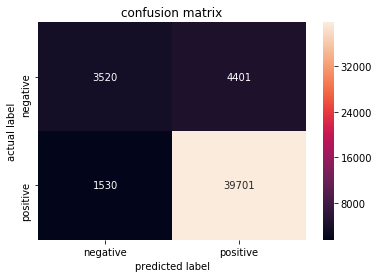

In [95]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest1=confusion_matrix(ytrain,predictra)
import seaborn as sns
classlabel=['negative','positive']

frame1=pd.DataFrame(rest1,index=classlabel,columns=classlabel)
sns.heatmap(frame1,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()

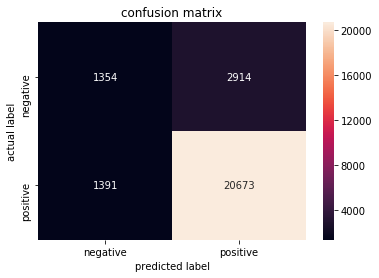

In [96]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest=confusion_matrix(ytest,predictra1)
import seaborn as sns
classlabel=['negative','positive']

frame=pd.DataFrame(rest,index=classlabel,columns=classlabel)
sns.heatmap(frame,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()

##WITH FEATURE ENGINEERING

In [97]:
#with hyper parameter tuning
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
cvscores=[]
cvscores1=[]
min_samples_split=[i for i in [5,10,100,200,300,400,500]]
depth=[i for i in [1,5,10,50,100,500,1000]]
for i in min_samples_split:
  for j in depth:
    knnx=DecisionTreeClassifier(min_samples_split=i,max_depth=j)
    knnx.fit(xtrainonehotencoding1,ytrain)
    predict1=knnx.predict_proba(xtrainonehotencoding1)[:,1]
    predix=knnx.predict(xtrainonehotencoding1)
    cvscores.append(roc_auc_score(ytrain,predict1))
    predict2=knnx.predict_proba(xcvonehotencoding1)[:,1]
    cvscores1.append(roc_auc_score(ycv,predict2))
optimal_k=np.argmax(cvscores1)
print(cvscores)
print(cvscores1)

[0.6066502171091797, 0.710468830759999, 0.7892978206232177, 0.970096098955356, 0.9947093908976008, 0.9995976585387135, 0.9995984531111232, 0.6066502171091797, 0.7104218116697372, 0.7882398022961771, 0.9665288515779187, 0.9922307352788444, 0.9981345889369659, 0.9981093830792532, 0.6066502171091797, 0.7101854837891596, 0.7816735324510155, 0.9416695376655048, 0.9721136882409753, 0.9819085369628242, 0.9819242967477668, 0.6066502171091797, 0.709726577651919, 0.7785790219760388, 0.9256225385268183, 0.9572354178517444, 0.9698729649572959, 0.9682238414032736, 0.6066502171091797, 0.709726577651919, 0.7784811579063977, 0.9138732881630197, 0.9462060990820893, 0.9611194822231813, 0.9589801794478864, 0.6066502171091797, 0.7095603390189087, 0.7773727232710274, 0.9020906137051015, 0.9362058465029832, 0.9515773580495547, 0.9497119378007126, 0.6066502171091797, 0.7095603390189087, 0.7772671415915267, 0.8987601856489806, 0.930468067664292, 0.9458091619379629, 0.9456965944513229]
[0.6027715309133982, 0.7

In [0]:
depthsy=depth*7
estimators2=[[i]*7 for i in min_samples_split]
estimatorsy=np.array(estimators2).flatten()


for training data


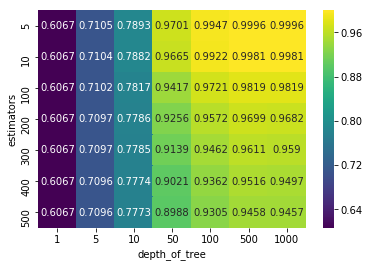

In [99]:
print('for training data')
dat=pd.DataFrame(np.round(cvscores,4),columns=['a'])
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

for cv data


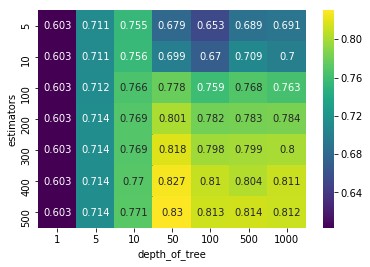

In [100]:
print('for cv data')
dat['a']=pd.DataFrame(np.round(cvscores1,3))
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

0.8183160234893058


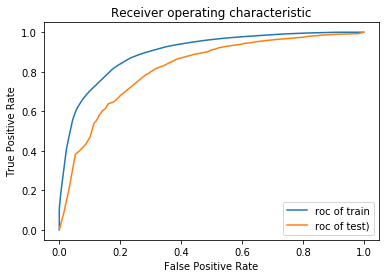

In [140]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
knne=DecisionTreeClassifier(min_samples_split=500,max_depth=50)
knne.fit(xtrainonehotencoding1,ytrain)
predictrain=knne.predict_proba(xtrainonehotencoding1)[:,1]
predictra=knne.predict(xtrainonehotencoding1)
fpr, tpr, thresh = metrics.roc_curve(ytrain, predictrain)
auc = metrics.roc_auc_score(ytrain, predictrain)
plt.plot(fpr,tpr,label="roc of train")
plt.legend()
predic=knne.predict_proba(xtestonehotencoding1)[:,1]
predictra1=knne.predict(xtestonehotencoding1)
fpr, tpr, thresh = metrics.roc_curve(ytest, predic)
auc = metrics.roc_auc_score(ytest, predic)
plt.plot(fpr,tpr,label="roc of test)")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
print(roc_auc_score(ytest, predic))

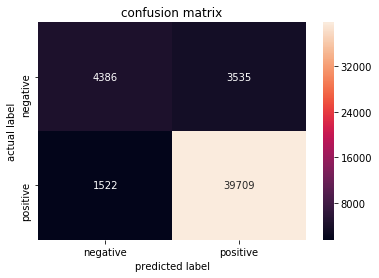

In [103]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest1=confusion_matrix(ytrain,predictra)
import seaborn as sns
classlabel=['negative','positive']

frame1=pd.DataFrame(rest1,index=classlabel,columns=classlabel)
sns.heatmap(frame1,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()

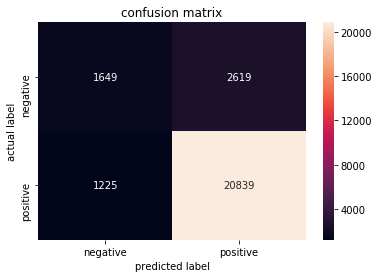

In [104]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest=confusion_matrix(ytest,predictra1)
rest1=confusion_matrix(ytrain,predix)
import seaborn as sns

classlabel=['negative','positive']

frame=pd.DataFrame(rest,index=classlabel,columns=classlabel)
sns.heatmap(frame,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()


# TFIDF WITH FEATURE ENGINEERING

In [121]:
#with hyper parameter tuning
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
cvscores=[]
cvscores1=[]
min_samples_split=[i for i in [5,10,100,500]]
depth=[i for i in [1,5,10,50,100,500,1000]]
for i in min_samples_split:
  for j in depth:
    knnx=DecisionTreeClassifier(min_samples_split=i,max_depth=j)
    knnx.fit(xtraintfidfencoding1,ytrain)
    predict1=knnx.predict_proba(xtraintfidfencoding1)[:,1]
    predix=knnx.predict(xtraintfidfencoding1)
    cvscores.append(roc_auc_score(ytrain,predict1))
    predict2=knnx.predict_proba(xcvtfidfencoding1)[:,1]
    cvscores1.append(roc_auc_score(ycv,predict2))
optimal_k=np.argmax(cvscores1)
print(cvscores)
print(cvscores1)

[0.6230798863008831, 0.7034843662795583, 0.769721863617626, 0.9640773155269178, 0.9887194708095086, 0.9997665181889979, 0.999744806000339, 0.6230798863008831, 0.7034843662795583, 0.7691154670819198, 0.9616005567775556, 0.9869877270345602, 0.9989547560702354, 0.9989088209053415, 0.6230798863008831, 0.7029494429865224, 0.764298740046071, 0.9382329247284777, 0.9679967421980055, 0.9866004365200165, 0.9861202927942071, 0.6230798863008831, 0.7019217607910764, 0.760259571772135, 0.8966934522894678, 0.9309217884128017, 0.9562925849666821, 0.9545130489626144]
[0.6302535576900201, 0.7067768987965067, 0.7448095041133748, 0.6689453745836995, 0.6758818560636642, 0.6925108660338157, 0.6915437071194364, 0.6302535576900201, 0.7062757683155658, 0.747160707509069, 0.6811318791725121, 0.6865875417763118, 0.6974827541690507, 0.6929667294993317, 0.6302535576900201, 0.7077198275475408, 0.7574926539215031, 0.7598064395096167, 0.7639771721634523, 0.749960461443716, 0.7523669018113827, 0.6302535576900201, 0.70

In [0]:
depthsy=depth*7
estimators2=[[i]*7 for i in min_samples_split]
estimatorsy=np.array(estimators2).flatten()


for training data


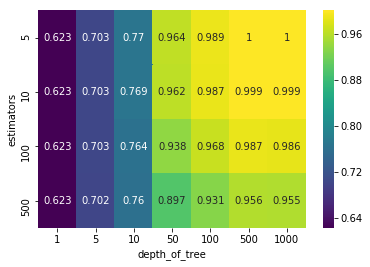

In [123]:
print('for training data')
dat=pd.DataFrame(np.round(cvscores,3),columns=['a'])
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

for cv data


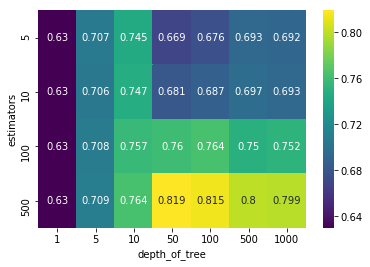

In [124]:
print('for cv data')
dat['a']=pd.DataFrame(np.round(cvscores1,3))
dat['depth_of_tree']=pd.DataFrame(depthsy)
dat['estimators']=pd.DataFrame(estimatorsy)
result = dat.pivot(index='estimators', columns='depth_of_tree', values='a')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

0.8163117790420371


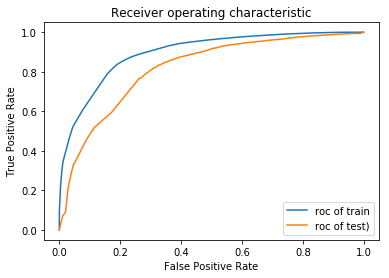

In [146]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
knne=DecisionTreeClassifier(min_samples_split=500,max_depth=50)
knne.fit(xtraintfidfencoding1,ytrain)
predictrain=knne.predict_proba(xtraintfidfencoding1)[:,1]
predictra=knne.predict(xtraintfidfencoding1)
fpr, tpr, thresh = metrics.roc_curve(ytrain, predictrain)
auc = metrics.roc_auc_score(ytrain, predictrain)
plt.plot(fpr,tpr,label="roc of train")
plt.legend()
predic=knne.predict_proba(xtesttfidfencoding1)[:,1]
predictra1=knne.predict(xtesttfidfencoding1)
fpr, tpr, thresh = metrics.roc_curve(ytest, predic)
auc = metrics.roc_auc_score(ytest, predic)
plt.plot(fpr,tpr,label="roc of test)")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
print(roc_auc_score(ytest, predic))

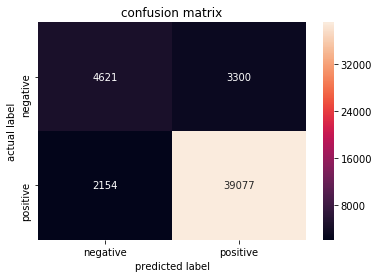

In [147]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest1=confusion_matrix(ytrain,predictra)
import seaborn as sns
classlabel=['negative','positive']

frame1=pd.DataFrame(rest1,index=classlabel,columns=classlabel)
sns.heatmap(frame1,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()

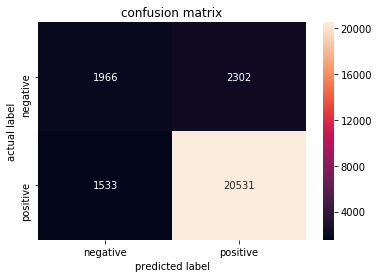

In [148]:
#plotting confusion matrix aftyer performing knn on top of svd data
from sklearn.metrics import confusion_matrix
rest=confusion_matrix(ytest,predictra1)
rest1=confusion_matrix(ytrain,predix)
import seaborn as sns

classlabel=['negative','positive']

frame=pd.DataFrame(rest,index=classlabel,columns=classlabel)
sns.heatmap(frame,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("predicted label")
plt.ylabel("actual label")
plt.show()


# [6] Conclusions

In [149]:
import pandas as pd
print('for decision tree')
data = [[500,50, 0.82], [500,50, 0.82],[120,9, 0.817],[120,7,0.73],[500,50, 0.82], [500,50, 0.816]]
pd.DataFrame(data, columns=["minimum_samples", "depth_of_tree",'auc'],index=['bow','tfidf','word2vec','averageword2vec','bow with feature engg.','tfidf with feature engg.'])

for decision tree


,minimum_samples,depth_of_tree,auc
bow,500,50,0.820
tfidf,500,50,0.820
word2vec,120,9,0.817
averageword2vec,120,7,0.730
bow with feature engg.,500,50,0.820
tfidf with feature engg.,500,50,0.816


## DOCUMENTATION,CONCLUSION AND KEYTAKEAWAYS

## FOR THE DECISION TREES OVER THE ANMAZON FINE FOED REVIEWS, WE HAVE ENCODED THE FEATURES INTO BAGOFWORDS,TFIDF,AVERAGE WORD2VEC,TFIDF WORD2VEC.WE HAVE DONE HYPERPARAMETER TUNING OVER THE MODELS USING THE CROSS VALIDATION DATA  AFTER FITTING THE TRAINING MODELS.WE HAVE DONE THE VISUALISATION OF DECISION TREES FORLESS DEPTH FOR BOTH BAGOF WORDS MODEL AND TFIDF MODEL WITH LOWER DEPTH.

## WE HAVE OBTAINED THE FEATURE IMPORTANCES AND PLOTTED THE BOTH POSITIVE AND NEGATIVE FEATURES IN THE WORDCLOUDS. WE HAVE REPRESENTED THE RESULTS OF AREA UNDER CURVE THAT WE HAVE OBTAINED. WE HAVE ALSO DONE THE FEATURE ENGINEERING TECHNIQUES ADDING THE LENGTH OF WORDS PRESENT IN THE SENTENCE. AND OBTAINED THE PERFORMANCE OF USING THE FEATURE ENGINEERING TECHNIQUE. MODELS PERFORMED WELL WE ARE ABLE TO ACHIEVE THE HIGHEST AUC VALUE OF 0.82 WITH BOTH BOW AND TFIDF.